# Lineage Tracking for Cells in the Mother Machine

In [1]:
from LineageTrack.lineage_tracker import LineageTrack
from LineageTrack.visualiser import Visualiser
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image, display, HTML

### comment out ###
from jupyterthemes import jtplot
jtplot.style(theme='oceans16')

### Data Preparation
Load the properties of cells from a directory containing the csv files **only** or load it with paths to every single file

The cell properties data can be obtained from `skimage.measure.regionprops` on the masked trench images

In [2]:
# mask_dir = ""
# channel_image_dir = ""
# save_dir = ".\\temp\\csv\\"
# generate_csv(mask_dir, channel_dir, save_dir=save_dir)

In [3]:
directory = ".\\example\\csv"    # the example includes the first 13 trenches from Charlie's Phage experiment
exp = LineageTrack.from_path(directory)
print(exp)
display(exp.df.head(1))
# or
# filepath1 = ""
# filepath2 = ""
# ...
# exp = LineageTrack.from_path(filepath1, filepath2, ...)

Looking for data at these locations:
.\example\csv\2022_04_22_PC_data_epoch_20_prob_99.csv
.\example\csv\2022_04_22_RFP_data_epoch_20_prob_99.csv
.\example\csv\2022_04_22_YFP_data_epoch_20_prob_99.csv
Finished loading the data
(11859, 11)

                Read 3 files
                Channels: ['PC', 'YFP', 'mCherry']
                Properties for each cell: ['PC_intensity_mean', 'YFP_intensity_mean', 'area', 'centroid-0', 'centroid-1', 'label', 'mCherry_intensity_mean', 'major_axis_length', 'minor_axis_length', 'time_(mins)', 'trench_id']
            


,trench_id,time_(mins),label,area,major_axis_length,minor_axis_length,centroid-0,centroid-1,PC_intensity_mean,mCherry_intensity_mean,YFP_intensity_mean
0,0,0,1,238,53.914722,7.221878,94.672272,65.420166,2048.146973,2647.348633,148.050415


### Tracking Algorithm: Strategy 3 on the Log Book

*Currently this algorithm is designed for exponential growth*

Model for cell growing: $L_{t+\Delta t} = L_t \times 2^{(\Delta t / \tau)}$

Model for one cell dividing during a time interval, Δt (very simplified and has big assumption): 
- Poisson distribution, $Pr(k|\lambda) = \frac{\lambda^k}{k!}e^{-\lambda}$
- $\lambda = \Delta t/T $
- Pr(divide) = Pr(k=1)
- Pr(no divide) = Pr(k=0)
- Assumptions: Division of a cell is independent of the previous division of the cell and its length; Division between cells are independent

#### STEP 1:
Estimate the growth time constant $\tau$, or the doubling time T, by observing the mother cell in some trenches (they can be the same thing but are measured in different ways here)

User need to select the period, e.g., exponential growth

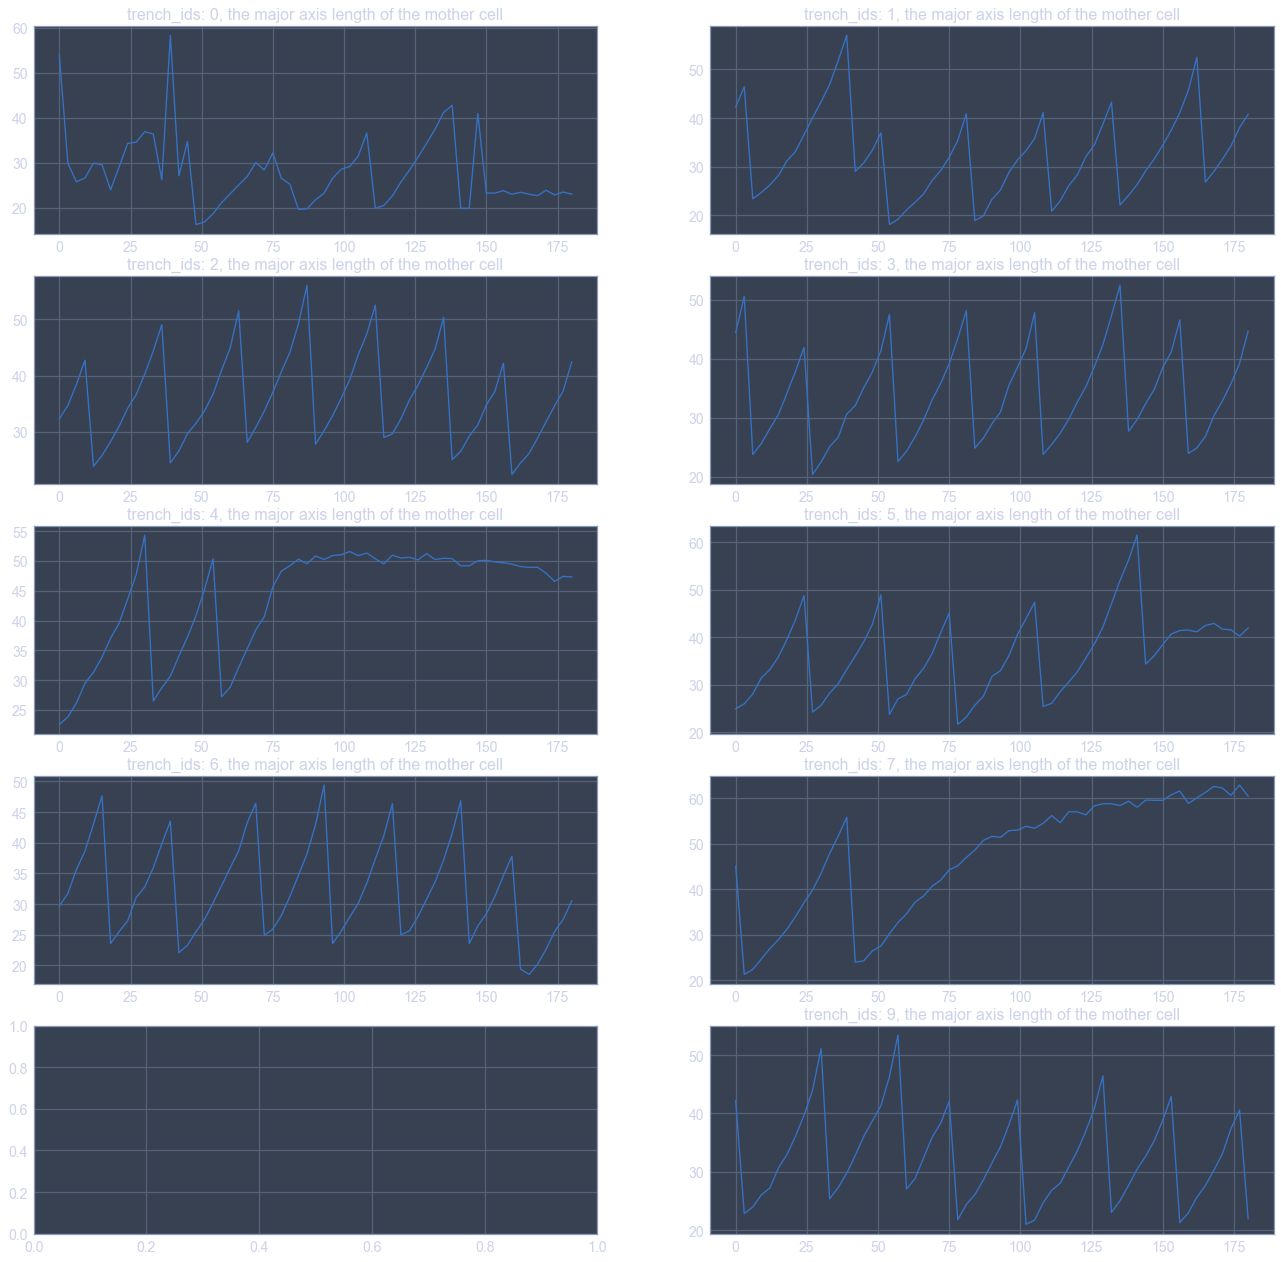

In [4]:
trench_list = [i for i in range(10)]

m = exp.get_mother_cell_growth(trench_list, plot=True)

Find the division times for trench 1

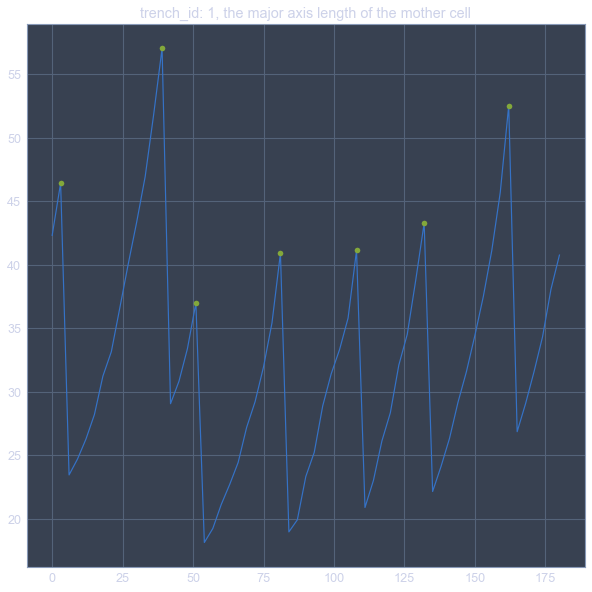

[[  3.          46.41300583]
 [ 39.          57.02418137]
 [ 51.          36.97775269]
 [ 81.          40.89678574]
 [108.          41.11452484]
 [132.          43.26797485]
 [162.          52.50556564]]


In [5]:
mcell1, idx1 = exp.find_division(1)

peaks = [mcell1[1][i, :] for i in idx1]
peaks = np.array(peaks)
print(peaks)

Select the peaks between the exponential growth phase, calculate intervals between division and for each interval, estimate the growth constant

> NOTE: the peak could also be lysis

the slope is estimated to be 0.038872735918546425
the intercept is estimated to be 4.501272528268139


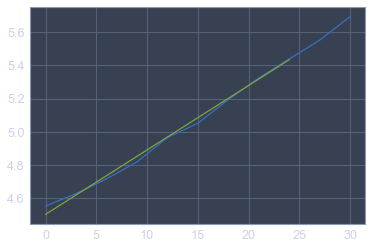

the slope is estimated to be 0.033439747875788996
the intercept is estimated to be 4.855506304192734


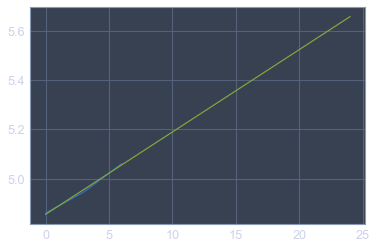

the slope is estimated to be 0.04031699186300881
the intercept is estimated to be 4.153692489401551


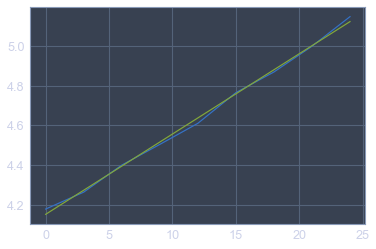

the slope is estimated to be 0.04608023245107278
the intercept is estimated to be 4.2417947414170545


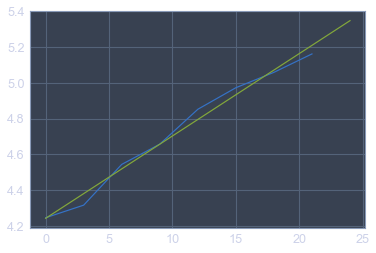

the slope is estimated to be 0.0493229777528664
the intercept is estimated to be 4.388885019014377


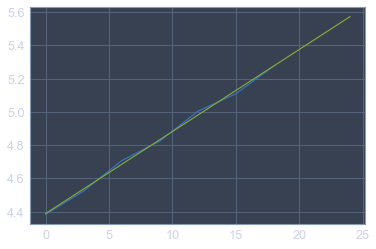

the slope is estimated to be 0.04304354489620594
the intercept is estimated to be 4.465180328222813


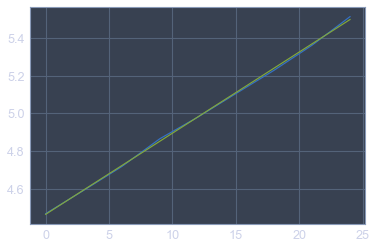

In [6]:
# since we are interested in  exponential growth, slice it according to the data
# in this case data between every peaks can be used
e_phase_idx1 = idx1[:]

exp.collect_model_para(mcell1, e_phase_idx1, plot=True)

In [7]:
print(exp.div_intervals)
print(exp.growth_taus)
print(exp.length_at_div)

[36.0, 12.0, 30.0, 27.0, 24.0, 30.0]
[0.038872735918546425, 0.033439747875788996, 0.04031699186300881, 0.04608023245107278, 0.0493229777528664, 0.04304354489620594]
[[[3.0, 39.0, 51.0, 81.0, 108.0, 132.0, 162.0], [46.41300582885742, 57.0241813659668, 36.977752685546875, 40.896785736083984, 41.114524841308594, 43.267974853515625, 52.50556564331055]]]


Repeat for trench 2, and so on

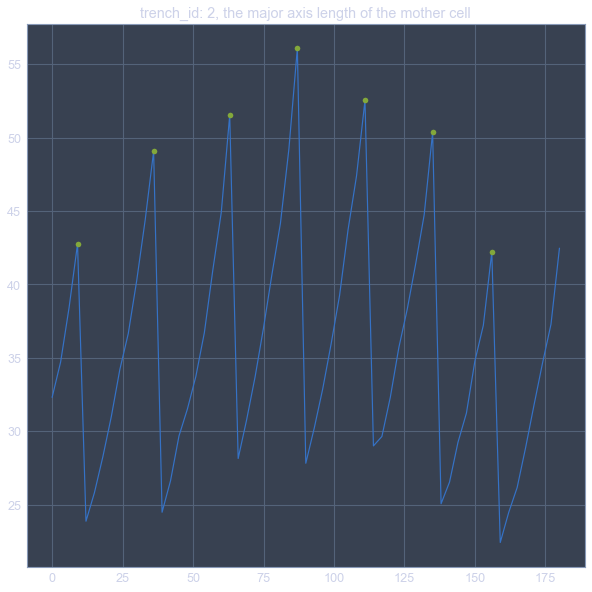

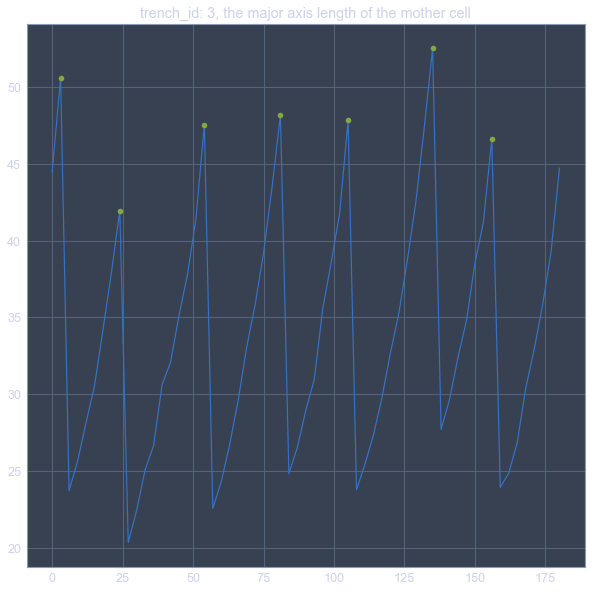

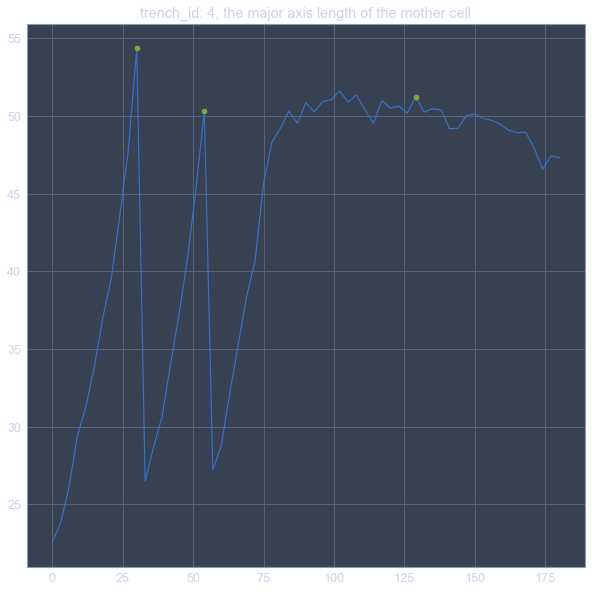

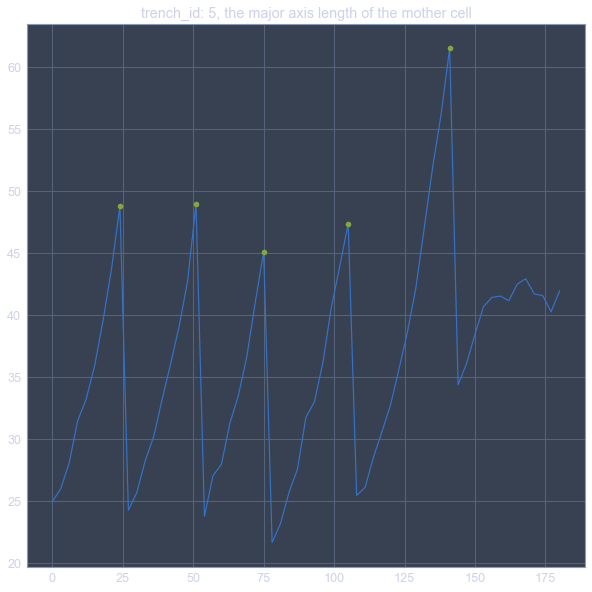

In [8]:
mcell2, idx2 = exp.find_division(2)
mcell3, idx3 = exp.find_division(3)
mcell4, idx4 = exp.find_division(4)
mcell5, idx5 = exp.find_division(5)

In [9]:
exp.collect_model_para(mcell2, idx2[:])
exp.collect_model_para(mcell3, idx3[:])
# slice it according to the data
e_phase_idx4 = idx4[:-1]    # do not use the last peak
exp.collect_model_para(mcell4, e_phase_idx4)
# this is just to show that collect_model_para only need to be run once for each mother cell
exp.collect_model_para(mcell4, e_phase_idx4)
exp.collect_model_para(mcell5, idx5[:])

In [10]:
exp.update_model_para(model="unif")


                    The average time interval for division is 26.08695652173913
                    The time constant for exponential growth is 23.95156924600458
                    The average division length is 48.36530671800886 with variance 29.00931377076993
                    


For some cases where you might want to set the parameters manually, e.g., mother cells are not representative of the whole population or cells are growing heterogeneously. Use:

`self.div_interval = some value` - used for setting up prior probability

or, 

`self.growth_tau = some value` - used for estimating the growth of the cells length

Tools to select mode of modelling will be developed later

To include the cells' length into our prior, esimate Gaussian cdf parameters. This is done in `update_model_para()`, but can also set manually by `self.div_length_para = (mean, var)`

$Pr(div | \lambda, length) = \frac{Pr(div, \lambda, length)}{Pr(length)Pr(\lambda)}$

Since length and $\lambda$ can be assumed to be independent, $Pr(div | \lambda, length) \propto Pr(div|\lambda) Pr(div|length)$

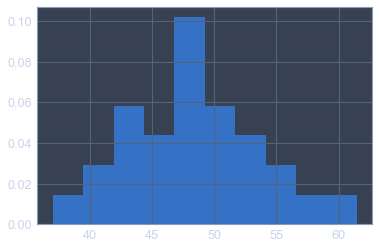

[46.41300582885742, 57.0241813659668, 36.977752685546875, 40.896785736083984, 41.114524841308594, 43.267974853515625, 52.50556564331055, 42.7536735534668, 49.063812255859375, 51.52674865722656, 56.0760383605957, 52.529659271240234, 50.35191345214844, 42.20262145996094, 50.5936164855957, 41.95100402832031, 47.537174224853516, 48.16990280151367, 47.82967758178711, 52.50795364379883, 46.605934143066406, 54.354766845703125, 50.34778594970703, 48.754451751708984, 48.92498016357422, 45.09147262573242, 47.36546325683594, 61.49014663696289]


In [11]:
import matplotlib.pyplot as plt

max_lengths = []
for i in exp.length_at_div:
    max_lengths += i[1]
plt.hist(max_lengths, density=True)
plt.show()
print(max_lengths)

In [12]:
exp.div_length_paras

(48.36530671800886, 29.00931377076993)

#### STEP 2:
For each frame in each trench, look at the current frame in the trench and predict a list of furture of the cells in the next frame with some probability (prior) by using the model from above: growth and division. 

Score each furture with a likelihood function, using y position and length. Select the one with the highest value of prior x likelihood. 

Can square the likelihood to diminish the effect of prior since the prior has not considered the dependence between divisions. 

**Interested cell's properties**
- Label: only consider the several cells at the top of the trench, the order is consistent
- Major axis length: relevant to cell growth, cell division
- Centroid y coordinates: relevant to cell growth and also the growth of all the previous cells

Since they are geometrical properties, I have decided to not normalise the features.

Run `track_trench` for specified trench, this function can have the following arguments:
- `trench` is the trench_id the track the cells
- `threshold` is the limit of the centroid y axis - this is to limit the number of cells to look at in each trench
- `max_dpf` is the maximum division per frame to simulate, 1 or 2 should be enough but in principle this value can go up to the total number of cells below the threshold, i.e. all cells divide. If it goes over the total number of cells it will instead use the total number.
- `mode` is to select the method used to search the cells' matching future, options are simple nearest neighbour 'KDTree' or sequence matching 'SeqMatch' (exclusively one-to-one matching, suggested)
- `p_sp` is the probability of all cells entering stationary phase (stop growing), default 0
- `show_details` will display details of the simulation if set to True, default False
- `ret_df` will return a pandas dataframe rather than a dictionary if set to True, default False

In [13]:
track_df, lysis_df = exp.track_trench(trench=1, threshold=250, max_dpf=3, show_details=False, ret_df=True)

Tracking over frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.33it/s]


#### Results:
The results are stored as a new set of Pandas DataFrame, containing all the cells that are below the threshold specified earlier. The colume parent_label shows the label of this cell in the previous frame. 

None means they are not matched. 

There is also a new DataFrame containing all the cells that is considered to be lysed or pushed out of the interested area of the trench, i.e., not matched in the algorithm.

In [14]:
# display(HTML(track_df.to_html()))
# display(HTML(lysis_df.to_html()))

By looking at the mask images, cells with the following label divide between certain time point:
- NO.2 between 0 and 3 min
- NO.1 between 3 and 6 min
- NO.3 between 24 and 27 min
- NO.2 between 27 and 30 min
- NO.1 between 39 and 42 min
- NO.1, 3, 4 between 51 and 54 min

By inspection, sometimes the error comes from all cells shifting between frames, i.e., the mother cells are not always at the end of the trench. An approach to solve this is to subtract the mother cell y position from all of the cells - but this is still left to be justified (what if the mother cell lysed from the last frame?)

Although this approach is working for the example data, except for at 51 min 3 cells divided. (setting max_dpf to 3 might enable the detection) 
> comment: it did not work because the probability of three cells dividing is too low

Further test on this algorithm will be done on many different sets of synthetic data for different growing condition - generated by [SyMBac](https://github.com/georgeoshardo/SyMBac)

There is also `track_trenches` for tracking multiple trenches (parallel workers):
the additional `save_dir` argument is the directory to save the csv files containing the tracking output, default "./temp/"

In [15]:
#exp.track_trenches([1,2,3], threshold=250, max_dpf=2, mode="SeqMatch", p_sp=0, special_reporter=None, show_details=False, save_dir="./temp/", ret_df=False)

`self.all_cells` contains dictionary of trench_id:list for all cells (Object Cell which has attributes `Cell.parent` - points to the parent Cell object; `Cell.divide` - bool for whether the cell divides in the next frame)

Use `pickle` to serialise and save in a file.

In [16]:
# print("In trench 1:")
# for cells in exp.all_cells[1]:
#     for cell in cells:
#         print(f"Cell: {cell}")
#         print(f"Divide?: {cell.divide}")
#         print(f"Parent: {cell.parent}")
#         print(f"Daughters: {cell.daughters}")
#         print(f"Barcode: {cell.barcode}\n")

It is time to visualise our results: first entry is the FOV

In [17]:
vis = Visualiser("000", track_df, lysis_df)
# or Visualiser.from_path(FOV, path1, path2)

Change the directory and template according to the filename and path of the masks
There are different ways to show the results, more ways might be developed. Currently there are two:
- `mode="connect_daughter"` will connect the daughters with a line when any cell divides
- `mode="landscape-line"` will concatenate all the masks for one trench and link the cells between frames
- `mode="barcode"`
- `mode="landscape-gray-scale"`

In [18]:
mask_dir = "F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr1_masks\\"
template_mask = ['xy', '_mCherry_TR', '_T', '-_epoch-20_prob-99.png']
vis.label_images(mask_dir, mode="connect_daughter", save_dir="F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr1_masks\\labelled_masks\\", template=template_mask)

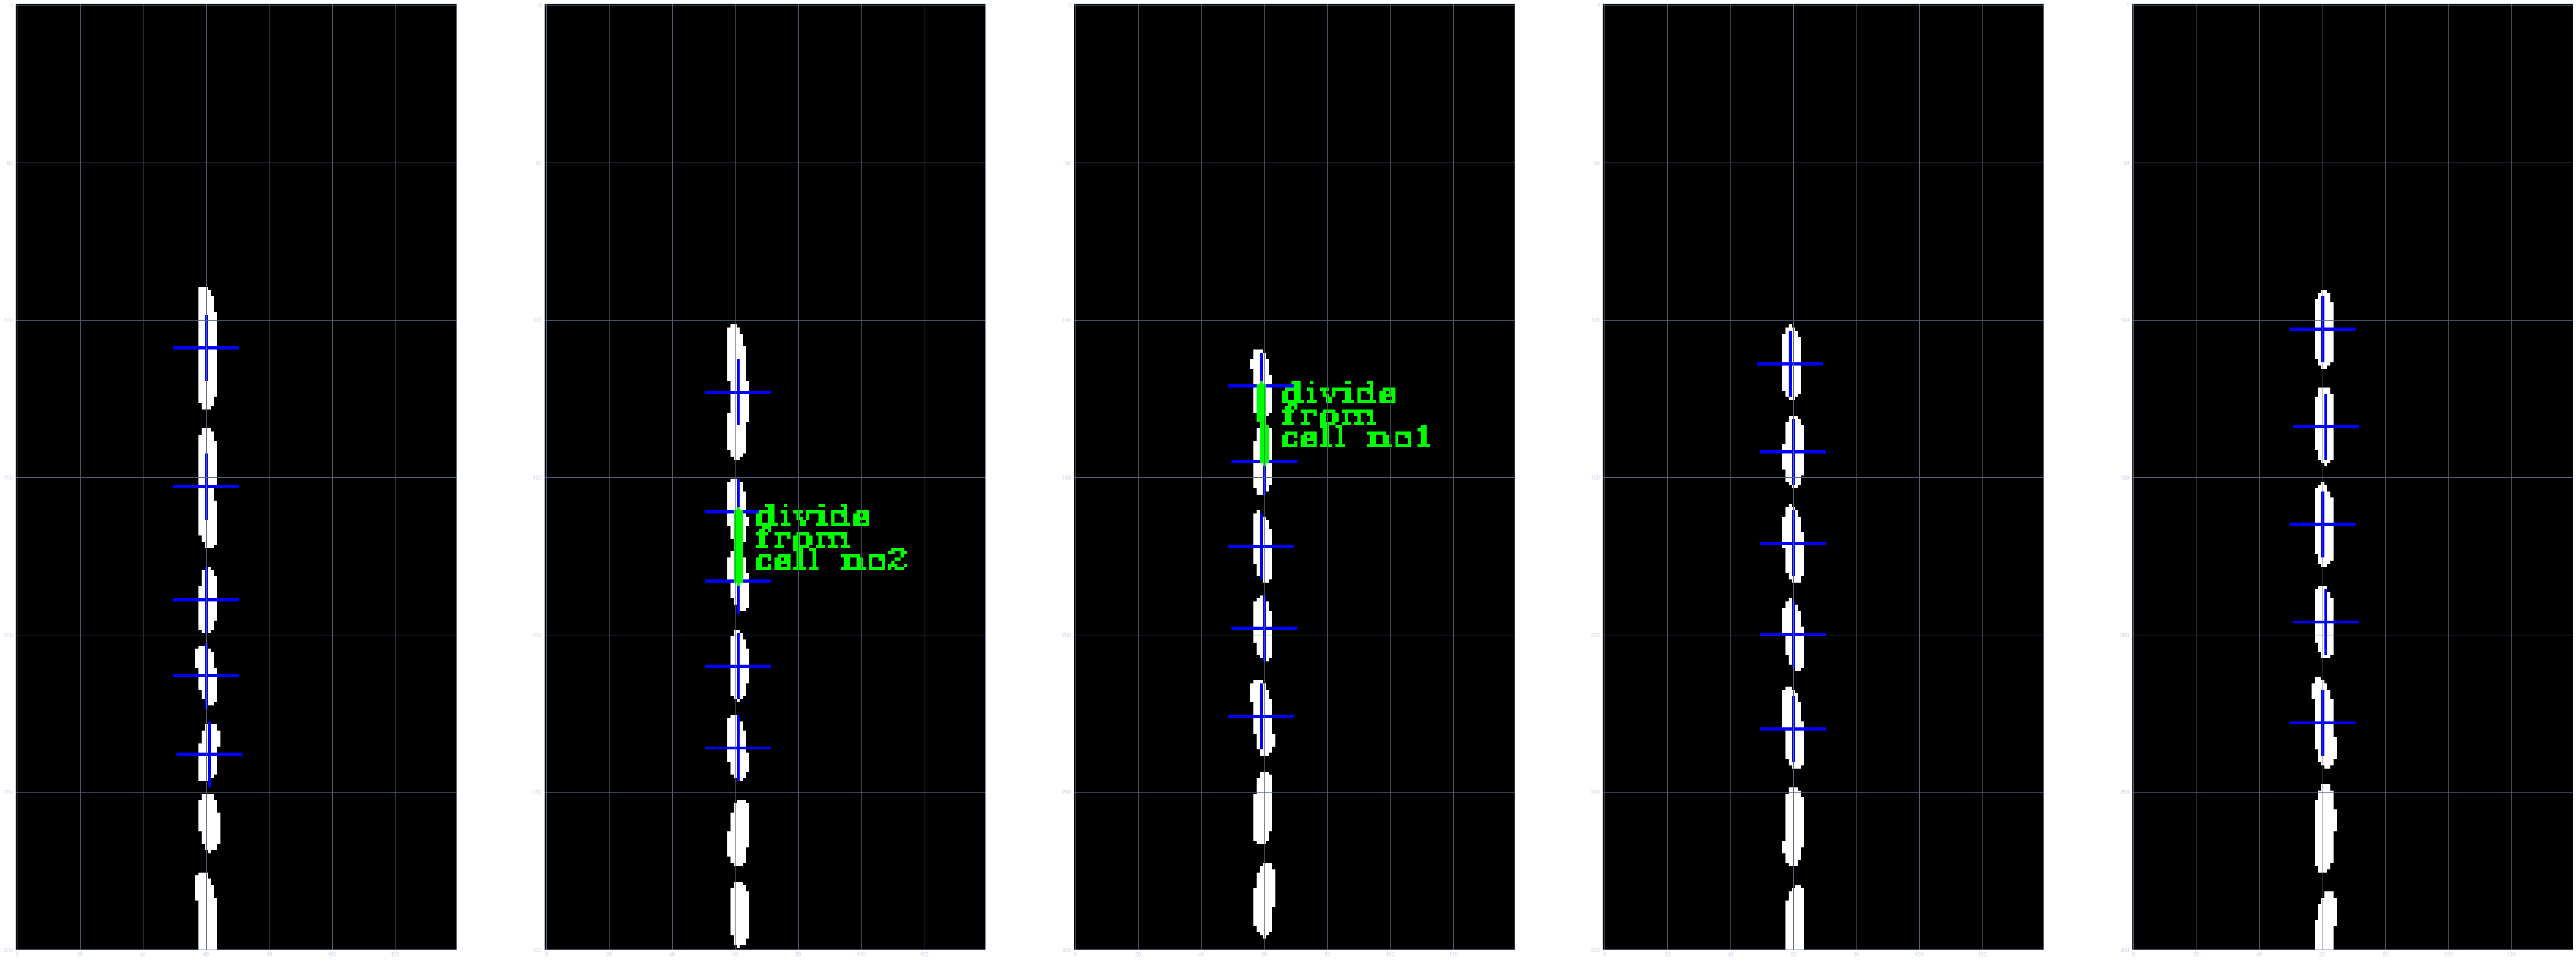

In [19]:
frames = 5

directory = "F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr1_masks\\labelled_masks\\"
files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
fig, ax = plt.subplots(1, frames, figsize=(100, 100))
ax_flat = ax.flatten()
for i in range(frames):
    img = mpimg.imread(directory + files[i])
    ax_flat[i].imshow(img)
    ax_flat[i].set_ylim(300)


In [20]:
vis.label_images(mask_dir, mode="landscape-line", save_dir="F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr1_masks\\landscape_masks\\", template=template_mask)

saved as F:\Cambridge\MENG\UROP 2022\Data\MMLT\tr1_masks\landscape_masks\\landscape_line_xy000_mCherry_TR1_T-_epoch-20_prob-99.png


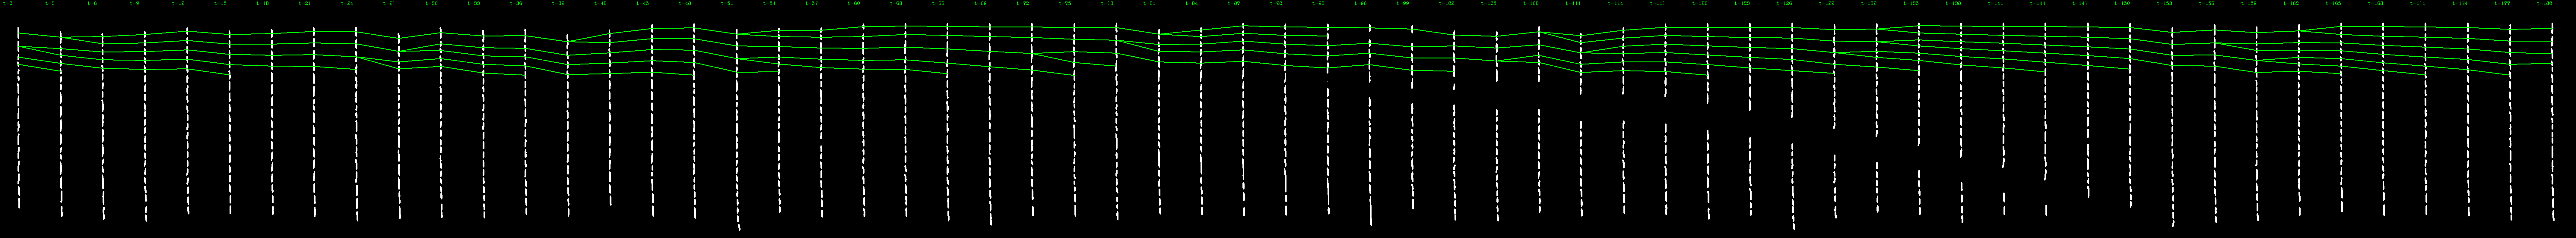

In [21]:
directory = "F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr1_masks\\landscape_masks\\"
files = [f for f in os.listdir(directory)if os.path.isfile(os.path.join(directory, f))]
display(Image(directory+files[0], unconfined=True))

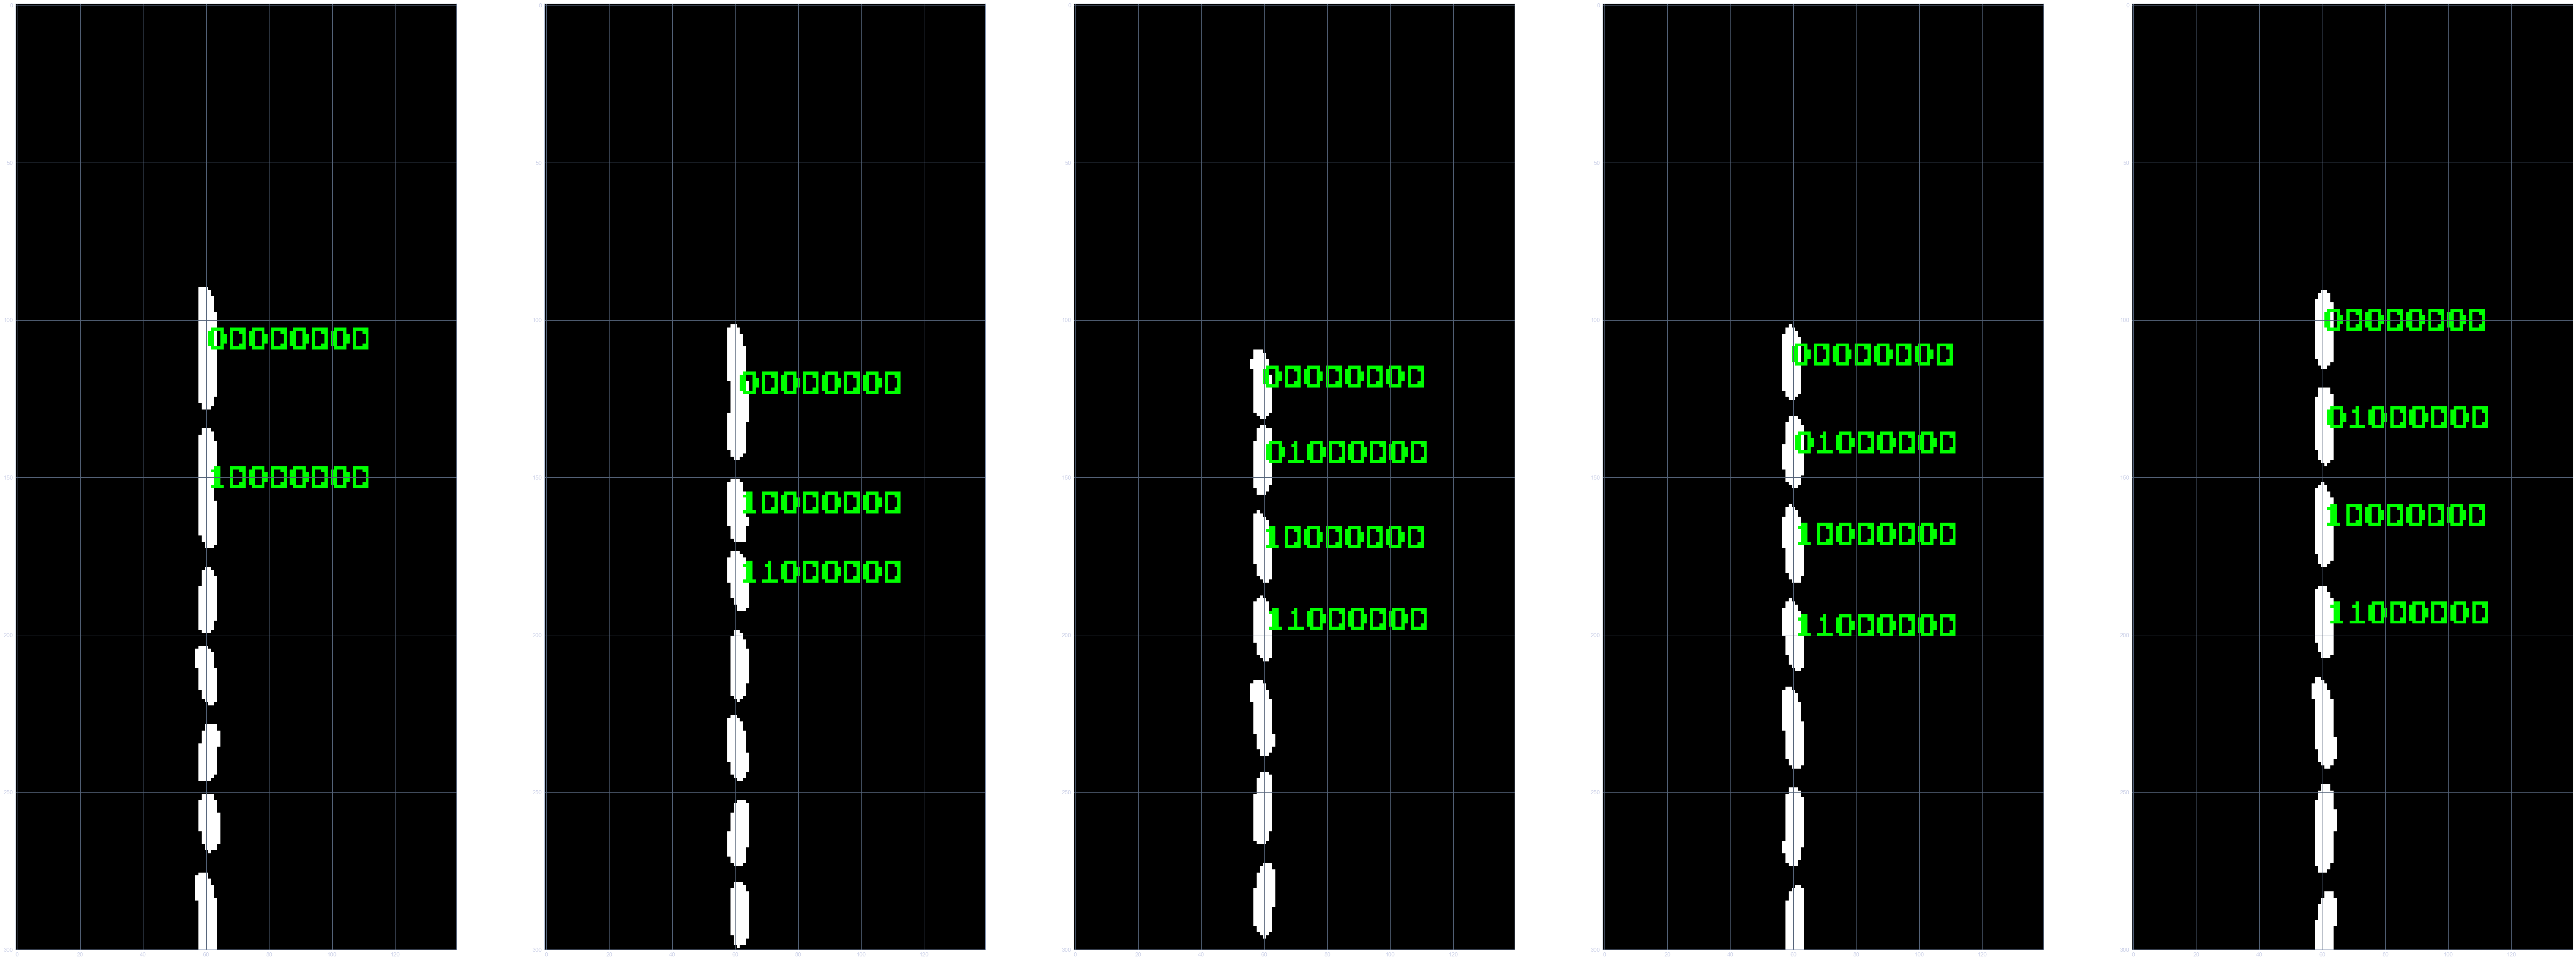

In [22]:
vis.label_images(mask_dir, mode="barcode", save_dir="F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr1_masks\\barcoded_masks\\", template=template_mask)
directory = "F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr1_masks\\barcoded_masks\\"
files = [f for f in os.listdir(directory)if os.path.isfile(os.path.join(directory, f))]

frames = 5
fig, ax = plt.subplots(1, frames, figsize=(100, 100))
ax_flat = ax.flatten()
for i in range(frames):
    img = mpimg.imread(directory + files[i])
    ax_flat[i].imshow(img)
    ax_flat[i].set_ylim(300)

saved as F:\Cambridge\MENG\UROP 2022\Data\MMLT\tr1_masks\landscape_gray\\landscape_gray_xy000_mCherry_TR1_T-_epoch-20_prob-99.png


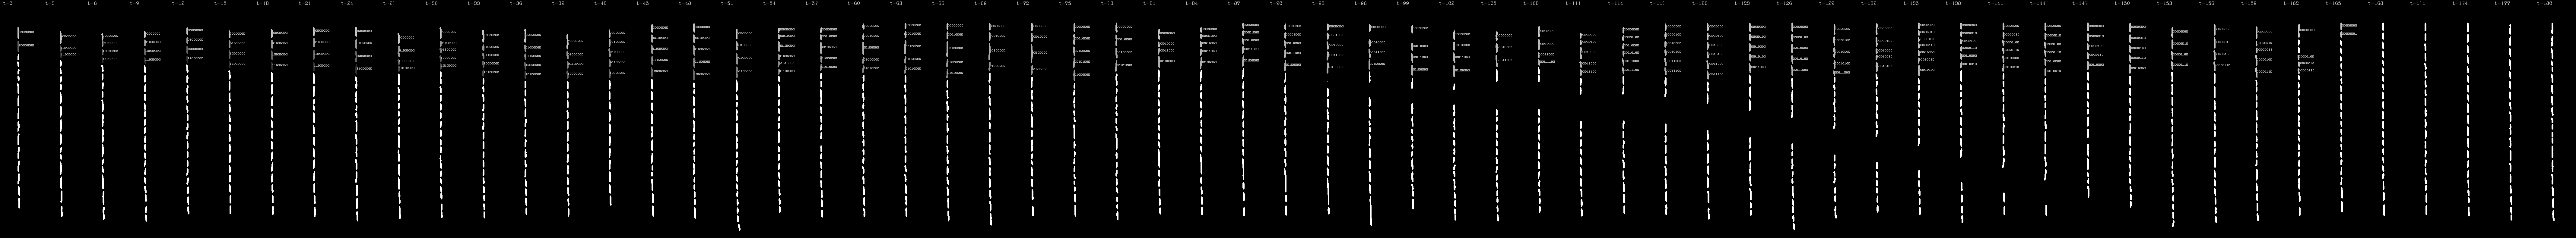

In [23]:
vis.label_images(mask_dir, mode="landscape-gray-scale", save_dir="F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr1_masks\\landscape_gray\\", template=template_mask)

directory = "F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr1_masks\\landscape_gray\\"
files = [f for f in os.listdir(directory)if os.path.isfile(os.path.join(directory, f))]
display(Image(directory+files[0], unconfined=True))

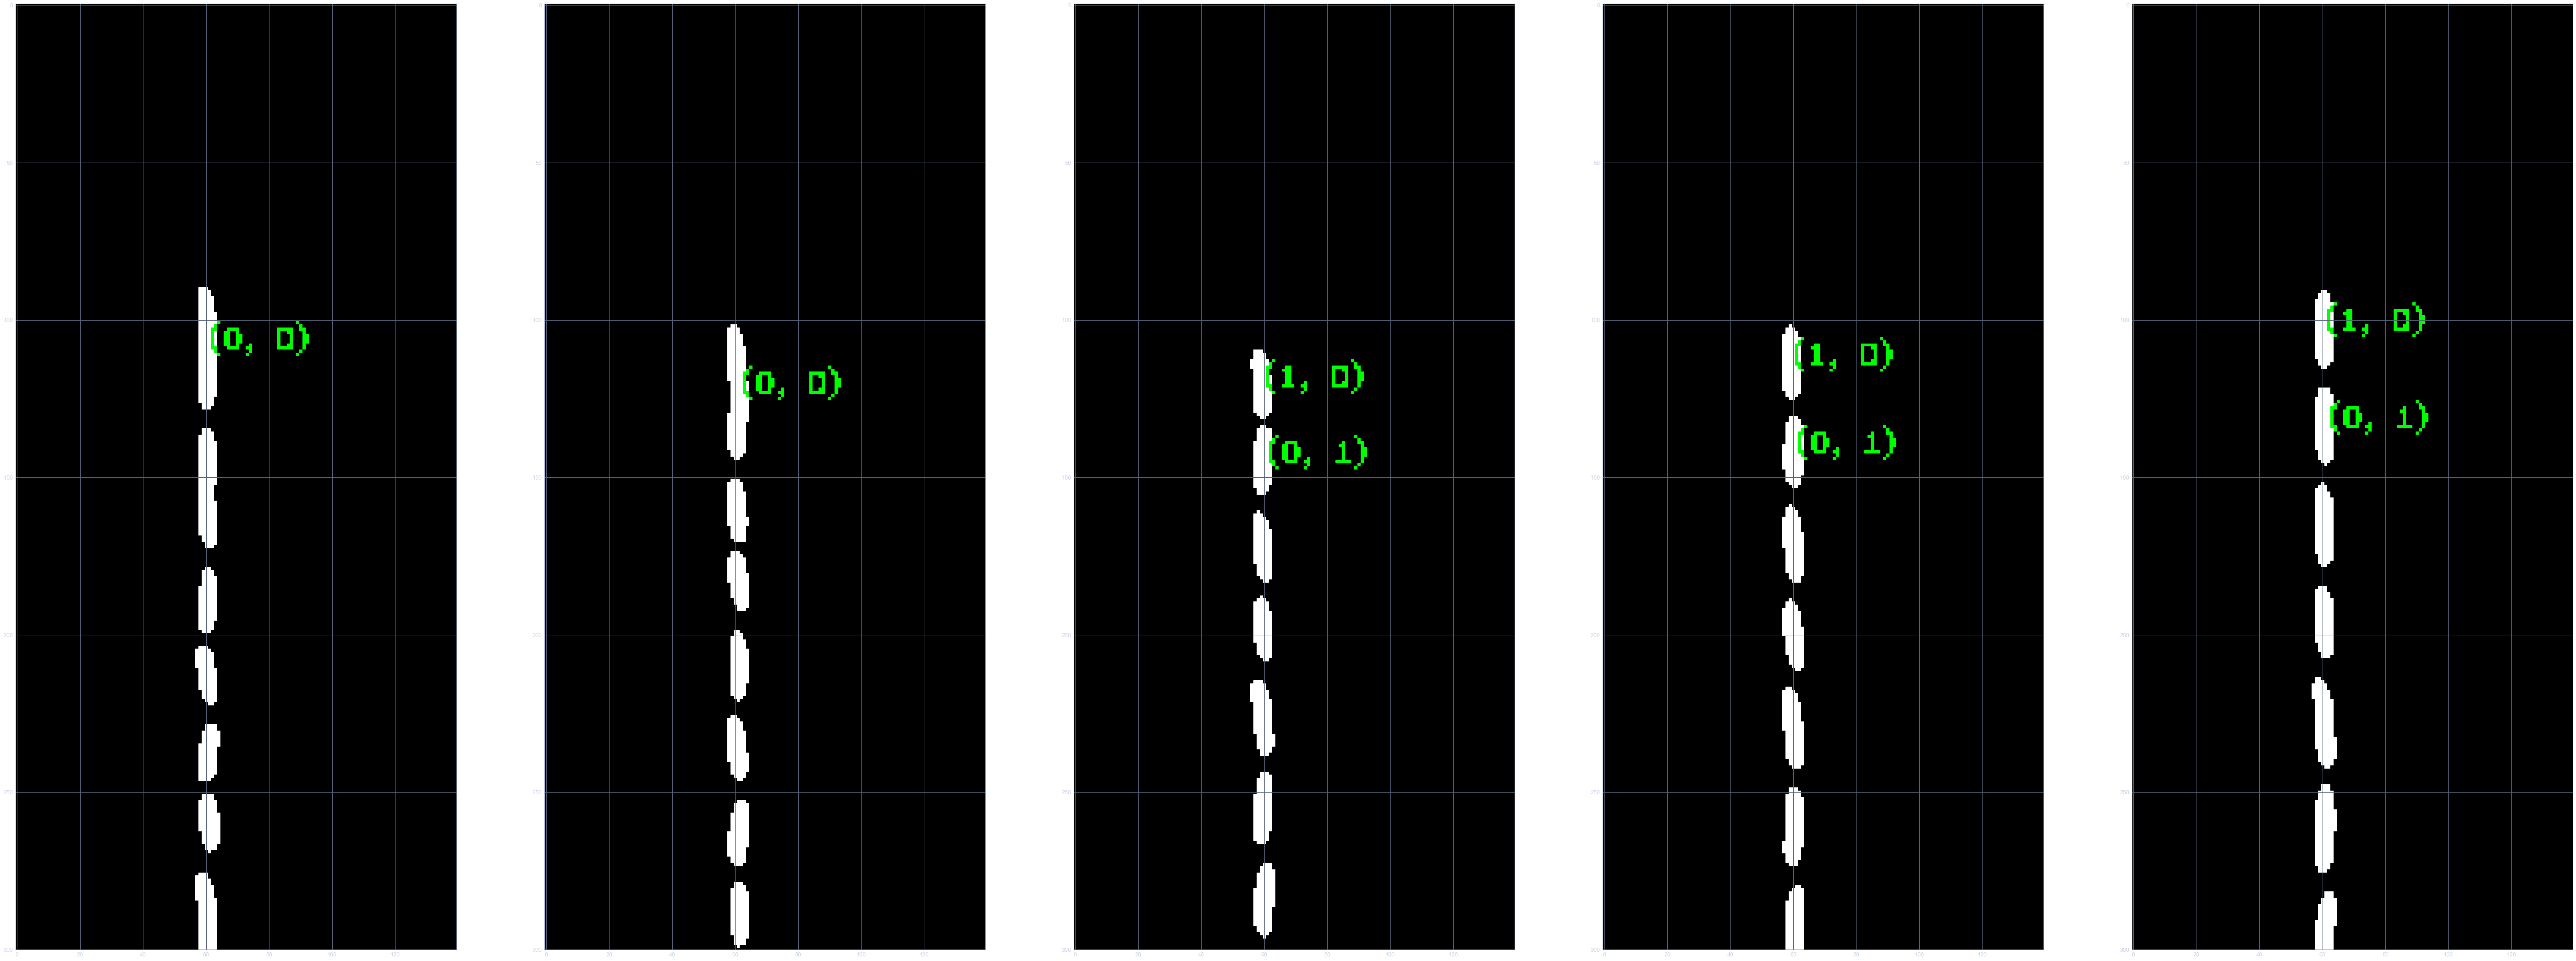

In [24]:
vis.label_images(mask_dir, mode="generation-by-poles", save_dir="F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr1_masks\\poles_masks\\", template=template_mask)
directory = "F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr1_masks\\poles_masks\\"
files = [f for f in os.listdir(directory)if os.path.isfile(os.path.join(directory, f))]

frames = 5
fig, ax = plt.subplots(1, frames, figsize=(100, 100))
ax_flat = ax.flatten()
for i in range(frames):
    img = mpimg.imread(directory + files[i])
    ax_flat[i].imshow(img)
    ax_flat[i].set_ylim(300)

Test it on another trench and try track more cells:

In [25]:
track_df_2, lysis_df_2 = exp.track_trench(trench=2, threshold=400, max_dpf=3, mode="SeqMatch", p_sp=0, special_reporter=None, show_details=False, ret_df=True)

Tracking over frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [01:33<00:00,  1.55s/it]


saved as F:\Cambridge\MENG\UROP 2022\Data\MMLT\tr2_masks\landscape_masks\\landscape_line_xy000_mCherry_TR2_T-_epoch-20_prob-99.png


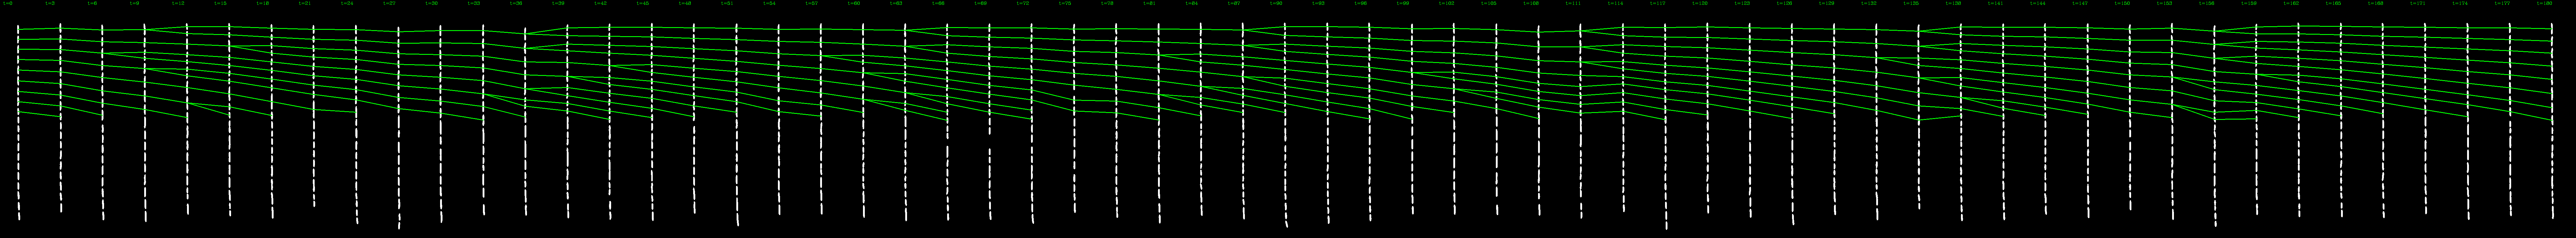

In [26]:
vis_2 = Visualiser("000", track_df_2, lysis_df_2)
mask_dir = "F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr2_masks\\"
vis_2.label_images(mask_dir, mode="landscape-line", save_dir="F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr2_masks\\landscape_masks\\", template=template_mask)
directory = "F:\\Cambridge\\MENG\\UROP 2022\\Data\\MMLT\\tr2_masks\\landscape_masks\\"
files = [f for f in os.listdir(directory)if os.path.isfile(os.path.join(directory, f))]
display(Image(directory+files[0], unconfined=True))